# Load libraries, define folders

In [2]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
scripts = 'Scripts'
import seaborn as sns
sys.path.append(scripts)
import glob
import numpy as np
pd.options.mode.chained_assignment = None 
from scipy import stats
from statsmodels.stats import multitest
import math
dataDirectory = 'qPCR/'
sns.set_style("white")
sns.set_style("ticks")

figureDirectory = 'Figures/'
if not os.path.isdir(figureDirectory):
    os.mkdir(figureDirectory)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
segments = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','HA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']


Will try and match the order in the manuscript to make things easy to follow. First up, validation of packaging qPCR. Using 10-fold dilutions of plasmid, starting at 0.01ng, we determine whether qPCR using these primers is reasonably linear, and specific.

First lets just plot linearity.


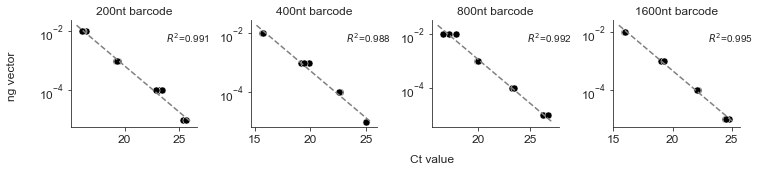

In [2]:
startingConcentration = 0.01
data = pd.read_csv(dataDirectory + 'barcode_qPCR_validation.csv')

columns = 4
g= plt.figure(1,(10,2), constrained_layout=True)
spec = g.add_gridspec(1,columns)
targets = ['200nt_barcode','400nt_barcode','800nt_barcode', '1600nt_barcode']
for column,target in enumerate(targets):
    plot = data.loc[(data.Plasmid == data.Target) & (data.Target == target),]
    plot['dilution'] = np.log10(plot.ng)
    slope, intercept, r_value, p_value, std_err = stats.linregress(plot.Cq,plot.dilution)
    ax = g.add_subplot(spec[0, column])
    sns.scatterplot(x='Cq', y='ng', data=plot,  ax = ax, color = ['0'], s=50)
    plt.yscale('log')
    x_vals = np.array(ax.get_xlim())
    y_vals = 10**(intercept+ slope * x_vals)
    plt.plot(x_vals, y_vals, '--', color='0.5')  
    ax.text(0.75, 0.8, '$R^{2}$=' + str(round(r_value**2,3)), transform=ax.transAxes, fontsize = 10)
    plt.title(target.replace('_',' '), fontsize=12)
    sns.despine()
    plt.ylabel('')
    plt.xlabel('')
g.text(0.55, -0.1, 'Ct value', ha='center')
g.text(-0.04, 0.5, 'ng vector', va='center', rotation='vertical')
plt.savefig('Figures/linearBarcodeqPCR.pdf', format='pdf', bbox_inches = "tight")

So how discriminatory are these qPCR's against one another? 

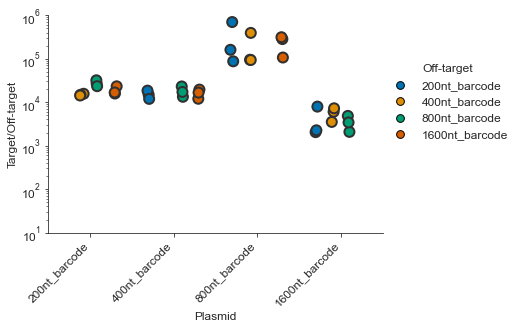

In [3]:
plot = data.loc[data.ng == 0.01,]
plot['specific'] = plot.Target == plot.Plasmid
plot = plot.pivot_table(index=['Plasmid', 'replicate'], columns='Target', values='Cq').reset_index()
newTargets = []
for target in targets:
    plot[target+'_difference'] = plot.apply(lambda row: row[target] - row[row.Plasmid], axis=1)
    newTargets += [target+"_difference"]
plot = plot[['Plasmid'] + newTargets].melt(id_vars=['Plasmid'], value_vars=newTargets)
plot['Relative efficiency'] = 2**plot['value']
plot['Target'] = plot.Target.str.slice(stop=-11)
ax = sns.stripplot(data=plot, hue='Target', x='Plasmid', y='Relative efficiency', order= targets, dodge=True, palette='colorblind', linewidth=2, size=10)
plt.yscale('log')
sns.despine()
plt.ylim(10,1000000)
plt.ylabel('Target/Off-target')
a = plt.xticks(rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0.,frameon=False, title='Off-target')
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
plt.savefig('Figures/barcodeqPCRSpecificity.pdf', format='pdf', bbox_inches = "tight")

Normalize everything to 1600nt. Correct via averages, then plot individual points. First lets plot minigenome as a function of length, corrected for initial abundance.

/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


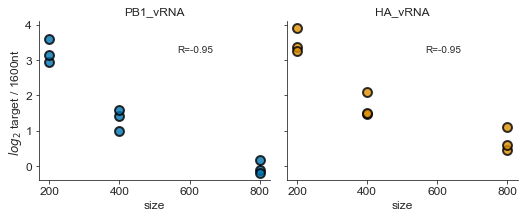

In [4]:
data = pd.read_csv(dataDirectory + 'barcode_qPCR_minigenome.csv')
data = data.pivot_table(index=['Replicate', 'Condition', 'segment'], columns=['Target'], values=['Cq']).reset_index()
data['200nt_barcode'] = data.Cq['1600nt_barcode'] - data.Cq['200nt_barcode']
data['400nt_barcode'] = data.Cq['1600nt_barcode'] - data.Cq['400nt_barcode']
data['800nt_barcode'] = data.Cq['1600nt_barcode'] - data.Cq['800nt_barcode']

#got to correct for Nopolymerase for minigenome
data = data.pivot_table(index=['segment','Replicate'], columns=['Condition'], values=['400nt_barcode','800nt_barcode', '200nt_barcode']).reset_index()
means = data.groupby(['segment']).mean().rename(columns={'400nt_barcode':'400nt_average','800nt_barcode':'800nt_average','200nt_barcode':'200nt_average'})
data = data.merge(means, on=['segment'])
data['400nt_minigenome'] = (data['400nt_barcode']['']['minigenome'] - data['400nt_average']['']['no_polymerase'])
data['800nt_minigenome'] = (data['800nt_barcode']['']['minigenome'] - data['800nt_average']['']['no_polymerase'])
data['200nt_minigenome'] = (data['200nt_barcode']['']['minigenome'] - data['200nt_average']['']['no_polymerase'])
data = data[['segment','400nt_minigenome','800nt_minigenome','200nt_minigenome' ]].melt(id_vars=['segment']).drop(columns=['Target','Condition']).rename(columns=str).rename(columns={'None':'Target'})
data['size'] = data.Target.str.slice(stop=-13).astype(int)
g = sns.lmplot(x="size", y="value", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=data, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":80, "linewidth":2,'edgecolor':'k'})
g.set_axis_labels("size", " ")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.text(-0.01, 0.5, '$log_{2}$ target / 1600nt', va='center', rotation='vertical')
axes = g.fig.axes

for segment, ax in enumerate(axes):
    spearman = round(data[data.segment == ["PB1_vRNA", "HA_vRNA"][segment]].corr('spearman')['size']['value'],2)
    ax.text(0.6, 0.8, 'R=' + str(spearman), transform=ax.transAxes, fontsize = 10)

plt.savefig('Figures/barcodeqPCRminigenome.pdf', format='pdf', bbox_inches = "tight")

What happens in cell replication? Infected at an MOI of 25 and analyzed results at 14hpi. Data already processed for 1600nt - 400nt.

Ran 1-sample t-test for significance for >0, but not graphing, put in text here with p-value for text.

HA_vRNA
0.0005785183310064618
PB1_vRNA
6.29039464184193e-05


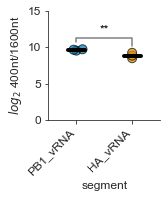

In [32]:
data = pd.read_csv(dataDirectory + 'oneRoundInfection.csv')
means = data.groupby(['segment']).mean().rename(columns={'starting':'average'}).drop(columns=['replicate','supernatant', 'cell'])
data = data.merge(means, on=['segment'])
data['enrichment'] = (data['cell'] - data['average'])
fig,ax = plt.subplots(figsize=(2,2))
sns.swarmplot(y='enrichment', x='segment', data=data, palette = fluColors, edgecolor='0',        
                dodge=True, linewidth=1, s=9,  alpha=0.7, zorder=5, order=["PB1_vRNA", "HA_vRNA"], ax=ax)
plt.ylabel('$log_{2}$ 400nt/1600nt')
plt.ylim(0,15)

sns.despine()
a = plt.xticks(rotation=45, ha='right')
tstat, pval = stats.ttest_ind(data[data.segment == 'HA_vRNA'].enrichment, data[data.segment == 'PB1_vRNA'].enrichment )
if pval < 0.05:
    y1 = data[data.segment == 'PB1_vRNA'].enrichment.max()
    y2 = data[data.segment == 'HA_vRNA'].enrichment.max()
    plt.plot([0,0,1,1],[y1+1, y1+1.6, y1+1.6, y2+1], lw=1.5, c='0.5')
    plt.text(0.5, y1+2.1, "**", ha='center', va='bottom', color='k')
for position, segment in enumerate(['PB1_vRNA', 'HA_vRNA']):
    y = data[data.segment == segment].enrichment.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)

pvals = []
for segment in sorted(set(data.segment)):
    values = data[data.segment == segment].enrichment
    tstat, pval = stats.ttest_1samp(values, 0)
    pvals += [pval]
qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
for segment, val in enumerate(qvals):
    print(sorted(set(data.segment))[segment])
    print(val)

plt.savefig('Figures/genomerepcell.pdf', format='pdf', bbox_inches = "tight")

Now packaging analysis.

HA_vRNA
0.0031570790885111248
PB1_vRNA
0.0031570790885111248


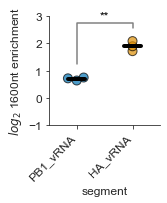

In [34]:
data = pd.read_csv(dataDirectory + 'barcode_qPCR_package.csv')
data = data.pivot_table(index=['Replicate', 'Condition', 'segment'], columns=['Target'], values='Cq').reset_index()
data['1600nt_barcode'] = data['400nt_barcode'] - data['1600nt_barcode']

data = data.pivot_table(index=['segment','Replicate'], columns=['Condition'], values='1600nt_barcode').reset_index()
means = data.groupby(['segment']).mean().rename(columns={'Minigenome':'average'}).drop(columns=['Supernatant','Replicate'])
data = data.merge(means, on=['segment'])
data['enrichment'] = (data['Supernatant'] - data['average'])
fig,ax = plt.subplots(figsize=(2,2))
sns.swarmplot(y='enrichment', x='segment', data=data, palette = fluColors, edgecolor='0',        
                dodge=True, linewidth=1, s=9,  alpha=0.7, zorder=5, order=["PB1_vRNA", "HA_vRNA"], ax=ax)
plt.ylabel('$log_{2}$ 1600nt enrichment')
plt.ylim(-1,3)
sns.despine()
plt.ylim()
a = plt.xticks(rotation=45, ha='right')
tstat, pval = stats.ttest_ind(data[data.segment == 'HA_vRNA'].enrichment, data[data.segment == 'PB1_vRNA'].enrichment )
if pval < 0.05:
    y1 = data[data.segment == 'PB1_vRNA'].enrichment.max()
    y2 = data[data.segment == 'HA_vRNA'].enrichment.max()
    plt.plot([0,0,1,1],[y1+0.5, y1+2, y1+2, y2+0.5], lw=1.5, c='0.5')
    plt.text(0.5, y1+2.1, "**", ha='center', va='bottom', color='k')
for position, segment in enumerate(['PB1_vRNA', 'HA_vRNA']):
    y = data[data.segment == segment].enrichment.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)
qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
pvals = []
for segment in sorted(set(data.segment)):
    values = data[data.segment == segment].enrichment
    tstat, pval = stats.ttest_1samp(values, 0)
    pvals += [pval]
qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
for segment, val in enumerate(qvals):
    print(sorted(set(data.segment))[segment])
    print(val)

plt.savefig('Figures/qPCR_packaging.pdf', bbox_inches = "tight")

Packaging in one round

HA_vRNA
0.005744361320851768
PB1_vRNA
0.005744361320851768


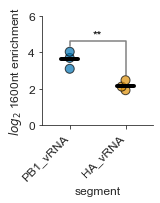

In [43]:
data = pd.read_csv(dataDirectory + 'oneRoundInfection.csv')
means = data.groupby(['segment']).mean().rename(columns={'cell':'average'}).drop(columns=['replicate','supernatant', 'starting'])
data = data.merge(means, on=['segment'])
data['enrichment'] = (data['supernatant'] - data['average'])*-1
fig,ax = plt.subplots(figsize=(2,2))
sns.swarmplot(y='enrichment', x='segment', data=data, palette = fluColors, edgecolor='0',        
                dodge=True, linewidth=1, s=9,  alpha=0.7, zorder=5, order=["PB1_vRNA", "HA_vRNA"], ax=ax)
plt.ylabel('$log_{2}$ 1600nt enrichment')
plt.ylim(0,6)

sns.despine()
a = plt.xticks(rotation=45, ha='right')
tstat, pval = stats.ttest_ind(data[data.segment == 'HA_vRNA'].enrichment, data[data.segment == 'PB1_vRNA'].enrichment )
if pval < 0.05:
    y1 = data[data.segment == 'PB1_vRNA'].enrichment.max()
    y2 = data[data.segment == 'HA_vRNA'].enrichment.max()
    plt.plot([0,0,1,1],[y1+0.3, y1+0.6, y1+0.6, y2+0.3], lw=1.5, c='0.5')
    plt.text(0.5, y1+0.7, "**", ha='center', va='bottom', color='k')
for position, segment in enumerate(['PB1_vRNA', 'HA_vRNA']):
    y = data[data.segment == segment].enrichment.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)
pvals = []
for segment in sorted(set(data.segment)):
    values = data[data.segment == segment].enrichment
    tstat, pval = stats.ttest_1samp(values, 0)
    pvals += [pval]
qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
for segment, val in enumerate(qvals):
    print(sorted(set(data.segment))[segment])
    print(val)
plt.savefig('Figures/genomepackcell.pdf', format='pdf', bbox_inches = "tight")

qPCR validating sort of interferferon beta. Already-corrected CT values for everything else in this notebook. Simple L32 correction. ~40-fold enrichment by qPCR

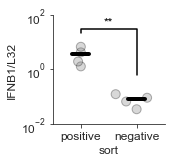

In [3]:
data = pd.read_csv(dataDirectory + 'qPCR_first_sort_CT.csv')
data['IFNB1'] = 2**data.IFNB1
data = data.groupby(['Replicate','sort','population']).mean().reset_index()




fig,ax = plt.subplots(figsize=(2,2))

sns.swarmplot(y='IFNB1', x='sort', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=["positive", "negative"], alpha=0.3, ax=ax)

sns.despine()
plt.yscale('log')
plt.ylim(0.01,100)
plt.ylabel('IFNB1/L32')
tstat, pval = stats.ttest_ind(data[data.sort == 'positive'].IFNB1, data[data.sort == 'negative'].IFNB1 )
if pval < 0.05:
    y1 = data[data.sort == 'positive'].IFNB1.max()
    y2 = data[data.sort == 'negative'].IFNB1.max()
    plt.plot([0,0,1,1],[y1+15, y1+25, y1+25, y2+0.5], lw=1.5, c='0')
    plt.text(0.5, y1+30, "**", ha='center', va='bottom', color='k')
    
for position, sort in enumerate(['positive', 'negative']):
    y = data[data.sort == sort].IFNB1.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=10)
plt.savefig('Figures/qPCR_beta_sorting.pdf',  bbox_inches = 'tight')

Validating qPCR to detect defectives.

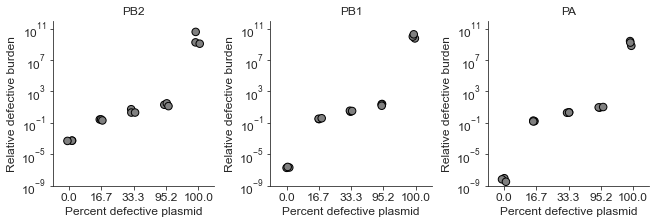

In [9]:
qPCRData = pd.read_csv(dataDirectory + 'defectiveqPCRValidation.csv')
qPCRData['defective_signal'] = 2**(qPCRData.FL - qPCRData.DI)
defectiveSegments = ['PB2', 'PB1', 'PA']
qPCRData['Percent DI'] = qPCRData['Percent DI'].astype(str)
g = plt.figure(1, (len(defectiveSegments)*3, 3), constrained_layout=True)
spec = g.add_gridspec(1,len(defectiveSegments))
for column, segment in enumerate(defectiveSegments):
    ax = g.add_subplot(spec[0,column])
    sns.stripplot(x='Percent DI', y='defective_signal', data=qPCRData[qPCRData.Segment == segment],  edgecolor='black',
            jitter=True, linewidth=1, s=7.5, palette=['0.5'], ax=ax, clip_on=False)
    sns.despine()
    plt.yscale('log')
    plt.ylabel('Relative defective burden')
    plt.xlabel('Percent defective plasmid')
    plt.ylim(0.000000001,1000000000000)
    plt.title(segment)
plt.savefig(figureDirectory + 'defective_qPCR_plas_control_whole.pdf', format = 'pdf', pad_inches = 1, bbox_inches = 'tight')


Replot but just on intermediate values

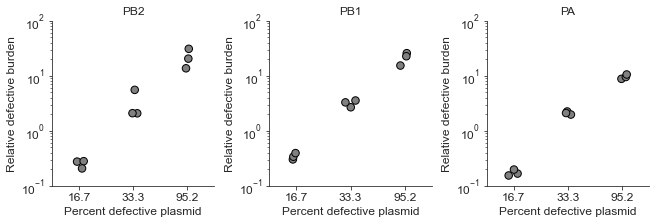

In [10]:
qPCRData['Percent DI'] = qPCRData['Percent DI'].astype(str)
g = plt.figure(1, (len(defectiveSegments)*3, 3), constrained_layout=True)
spec = g.add_gridspec(1,len(defectiveSegments))
for column, segment in enumerate(defectiveSegments):
    ax = g.add_subplot(spec[0,column])
    sns.stripplot(x='Percent DI', y='defective_signal', data=qPCRData[(qPCRData.Segment == segment) & (
                qPCRData['Percent DI'].isin(['16.7','33.3','95.2']))],  edgecolor='black',
            jitter=True, linewidth=1, s=7.5, palette=['0.5'], ax=ax, clip_on=False)
    sns.despine()
    plt.yscale('log')
    plt.ylabel('Relative defective burden')
    plt.xlabel('Percent defective plasmid')
    plt.ylim(0.1,100)
    plt.title(segment)
plt.savefig(figureDirectory + 'defective_qPCR_plas_control_intermediate.pdf', format = 'pdf', pad_inches = 1, bbox_inches = 'tight')

Analysis of sorted populations. 2 biological replicates, 3 technical replicates. IFN enriched/IFN depleted for each signal. Log-transformed, base 10. Numbers >0 represent an enrichemnt of deletions with interferon, <0 represent a depletion.

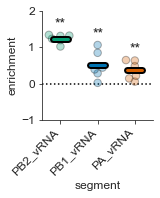

In [136]:
data = pd.read_csv(dataDirectory + 'qPCR_defective_IFN_validation.csv').dropna(axis=1)
data = data.pivot_table(index=['Viral population', 'Replicate', 'segment'], columns=['Interferon state'], values='Relative defective burden').reset_index()
data['enrichment'] = np.log2(data['Interferon enriched']/data['Interferon depleted'])
fig,ax = plt.subplots(figsize=(2,2))
order = ['PB2_vRNA','PB1_vRNA','PA_vRNA']
sns.swarmplot(x='segment', y='enrichment', data=data, hue='segment', order=order,  palette = fluColors, edgecolor='0',        
                linewidth=1, s=7.5, ax = ax, alpha=0.3, zorder=5)
sns.despine()
plt.legend([],[], frameon=False)
ax.axhline(y=0, color='k', linestyle=':',alpha=1)
plt.ylim(-1,2)
pvals = []
for segment in order:
    pvals += [stats.ttest_1samp(data[data.segment == segment].enrichment,1)[1]]
retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
for position, value in enumerate(retain):
    if value:
        # statistical annotation
        y = data[data.segment == order[position]].enrichment.max() + 0.1
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
    y = data[data.segment == order[position]].enrichment.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=3, c=fluColors[segments[position]], zorder=10)
    plt.plot([position-0.2, position+0.2], [y, y], lw=7, c='k', zorder=8)


a = plt.xticks(rotation=45, ha='right')

        

plt.savefig(figureDirectory + 'defectiveqPCRsort.pdf', format = 'pdf', pad_inches = 1, bbox_inches = 'tight')


qPCR showing that one PB1 deletion differs in interferon stimulation than another. Data already corrected for L32 and raised to a power of 2 so just graph.

MOI 0.5, 8h.

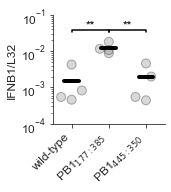

In [5]:
data = pd.read_csv('qPCR/PB1_mutants_qPCR.csv')
fig, ax = plt.subplots(1,1,figsize=[2,2])
order = ['wild-type', 'PB1 ∆385-2163', 'PB1 ∆351-1896']

sns.swarmplot(y='IFNB1', x='strain', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3)

sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('IFNB1/L32')
plt.yscale('log')
plt.ylim(0.0001,0.1)
#stats!
pvals = []
corresponding = []
for position, strain, in enumerate(order):
    for second, secondStrain in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_ind(data[data.strain == strain].IFNB1, data[data.strain == secondStrain].IFNB1 )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        x1, x2 = corresponding[position]
        y = data.IFNB1.max() + 0.015 + offset
        h = 0.005
        plt.plot([x1, x1, x2, x2], [y,y+h, y+h, y], lw=1.5, c='k')
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color='k')
    y = data[data.strain == order[position]].IFNB1.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=9)

a = plt.xlabel('')
#change names to match manuscript
displayNames = ['wild-type', 'PB1$_{177:385}$', 'PB1$_{445:350}$']
a =plt.xticks(np.arange(0,3,1),displayNames)

plt.savefig(figureDirectory + 'PB1_mutantsIFNB1_qPCR.pdf', bbox_inches="tight")






Compare HA expression

/Users/alistair/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


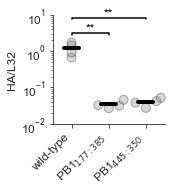

In [4]:
fig, ax = plt.subplots(1,1,figsize=[2,2])
order = ['wild-type', 'PB1 ∆385-2163', 'PB1 ∆351-1896']
sns.swarmplot(y='HA', x='strain', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)

plt.ylim(0.01,10)
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('HA/L32')
plt.yscale('log')
#stats!
pvals = []
corresponding = []
for position, strain, in enumerate(order):
    for second, secondStrain in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_ind(data[data.strain == strain].HA, data[data.strain == secondStrain].HA )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        x1, x2 = corresponding[position]
        y = data.HA.max() + 1 + offset
        h = 0.5
        plt.plot([x1, x1, x2, x2], [y,y+h, y+h, y], lw=1.5, c='k')
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color='k')
        offset += 5
    y = data[data.strain == order[position]].HA.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
a =plt.xticks(np.arange(0,3,1),displayNames)

plt.savefig(figureDirectory + 'PB1_mutantsHA_qPCR.pdf', bbox_inches="tight")

What if this is due to packaging differences? Compare PB1/HA ratios normalized to that achieved in WT

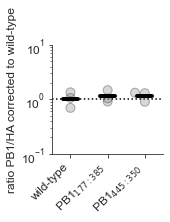

In [6]:
data = pd.read_csv('qPCR/particlePackaging.csv')
data['ratio'] = data.HA - data.PB1
correction = data.groupby(['strain']).mean().ratio['wild-type']
data['ratio'] = 2**(data.ratio - correction)
fig, ax = plt.subplots(1,1,figsize=[2,2])
order = ['wild-type', 'PB1 ∆385-2163', 'PB1 ∆351-1896']
sns.swarmplot(y='ratio', x='strain', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)

plt.ylim(0.1,10)
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('ratio PB1/HA corrected to wild-type')
plt.yscale('log')
#stats!
pvals = []
corresponding = []
for position, strain, in enumerate(order):
    for second, secondStrain in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_ind(data[data.strain == strain].ratio, data[data.strain == secondStrain].ratio )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        x1, x2 = corresponding[position]
        y = data.ratio.max() + 1 + offset
        h = 0.5
        plt.plot([x1, x1, x2, x2], [y,y+h, y+h, y], lw=1.5, c='k')
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color='k')
        offset += 5
    y = data[data.strain == order[position]].ratio.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
a =plt.xticks(np.arange(0,3,1),displayNames)
ax.axhline(y=1, color='k', linestyle=':',alpha=1)

plt.savefig(figureDirectory + 'particlePackageRatios.pdf', bbox_inches="tight")

Is PB1-177:385 detected by RIG-I? See if RIG-I silencing reduces interferon induction by this virus. Two siRNAs tested, confirmed to silence by qPCR against RIG-I.

/Users/alistair/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alistair/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


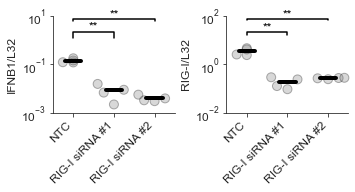

In [46]:
data = pd.read_csv('qPCR/RIGI_siRNA.csv')
data['IFNB1/L32'] = 2**(data.L32 - data.IFNB1)
data['RIG-I/L32'] = 2**(data.L32 - data['RIG-I'])


fig, axes = plt.subplots(1,2,figsize=[5,2])
fig.tight_layout()
ax = axes[0]
plt.sca(ax)
order = [ 'NTC', 'RIG-I siRNA #1', 'RIG-I siRNA #2']
sns.swarmplot(y='IFNB1/L32', x='treatment', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)
plt.yscale('log')
plt.ylim(0.001,10)
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('IFNB1/L32')
#stats!
pvals = [1]
corresponding = []
#just compare to NTC
for position, treatment, in enumerate(order[1:]):
    tstat, pval = stats.ttest_ind(data[data.treatment == 'NTC']['IFNB1/L32'], data[data.treatment == treatment]['IFNB1/L32'])
    pvals += [pval]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = data['IFNB1/L32'].max() + 1 + offset
        h = 1
        plt.plot([0, 0, position, position], [y,y+h, y+h, y], lw=1.5, c='k')
        plt.text((position)*.5, y+h, "**", ha='center', va='bottom', color='k')
        offset += 5
    y = data[data['treatment'] == order[position]]['IFNB1/L32'].mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
a =plt.xticks(np.arange(0,3,1),order)


ax = axes[1]
plt.sca(ax)
order = ['NTC', 'RIG-I siRNA #1', 'RIG-I siRNA #2']
sns.swarmplot(y='RIG-I/L32', x='treatment', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)
plt.yscale('log')
plt.ylim(0.01,100)
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('RIG-I/L32')
#stats!
pvals = [1]
corresponding = []
#just compare to untreated
for position, treatment, in enumerate(order[1:]):
    tstat, pval = stats.ttest_ind(data[data.treatment == 'NTC']['RIG-I/L32'], data[data.treatment == treatment]['RIG-I/L32'])
    pvals += [pval]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 10
for position, val in enumerate(pvals):
    if val:
        y = data['RIG-I/L32'].max() + 1 + offset
        h = 5
        plt.plot([0, 0, position, position], [y,y+h, y+h, y], lw=1.5, c='k')
        plt.text((position)*.5, y+h, "**", ha='center', va='bottom', color='k')
        offset += 50
    y = data[data['treatment'] == order[position]]['RIG-I/L32'].mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
a =plt.xticks(np.arange(0,3,1),order)
plt.savefig(figureDirectory + 'RIGIsilencing.pdf', bbox_inches="tight")

IFNL1 sort qPCR

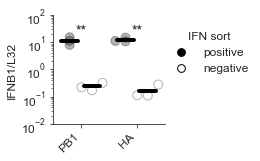

In [5]:
data = pd.read_csv(dataDirectory + 'qPCR_library_sort_CT.csv')
fig,ax = plt.subplots(figsize=(2,2))

sns.swarmplot(y='IFNB1', x='library', data=data, hue='sort', order = ['PB1','HA'],hue_order = ["positive", "negative"],
               palette = ['0','1'], edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False)


sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.yscale('log')
ax.get_legend().remove()
a = plt.xlabel('')
plt.ylim(0.01,100)
plt.ylabel('IFNB1/L32')
a = plt.xticks(rotation=45, ha='right')
ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 0.9), loc=2, borderaxespad=0.,frameon=False, title='IFN sort')

pvals =[]
for library in ['PB1','HA']:
    currFrame = data[data['library'] == library]
    tstat, pval = stats.ttest_ind(currFrame[currFrame.sort == 'positive'].IFNB1, currFrame[currFrame.sort == 'negative'].IFNB1 )
    pvals += [pval]
    
    
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

for position, val in enumerate(pvals):
    currFrame = data[data.library == ['PB1','HA'][position]]
    if val:
        y = currFrame.IFNB1.max()           
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
    y = currFrame[currFrame.sort == 'positive'].IFNB1.mean()
    plt.plot([position-0.35, position-0.05], [y, y], lw=4, c='k', zorder=9)
    y = currFrame[currFrame.sort == 'negative'].IFNB1.mean()
    plt.plot([position+0.05, position+0.35], [y, y], lw=4, c='k', zorder=9)
#from https://stackoverflow.com/questions/30887920/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
                      
plt.savefig(figureDirectory + 'IFNL1sortlibraries.pdf', bbox_inches="tight")

Comparing HA variants to one-another. Include less stimulatory PB1 for comparison. 

MOI 0.5, 14h timepoint.

/Users/alistair/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


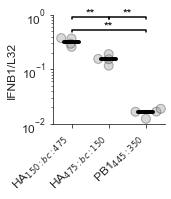

In [6]:
data = pd.read_csv('qPCR/HAcomparison.csv')
fig, ax = plt.subplots(1,1,figsize=[2,2])
order = ['HA150475', 'HA475150', 'PB1445350']

sns.swarmplot(y='IFNB1', x='strain', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)


plt.ylim(0.01,1)
#a = plt.yticks(np.arange(0, 0.61, 0.1))
plt.yscale('log')
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('IFNB1/L32')
#stats!
pvals = []
corresponding = []
for position, strain, in enumerate(order):
    for second, secondStrain in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_ind(data[data.strain == strain].IFNB1, data[data.strain == secondStrain].IFNB1 )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
numPos = len(order) * 2
for position, val in enumerate(pvals):
    if val:
        x1, x2 = corresponding[position]
        x1 = ((x1*2+1)/numPos)
        x2 = ((x2*2+1)/numPos)
        #just for this graph
        if (x1 == (1/6)) & (x2 == 0.5):
            y = 0.72 + 2*0.12
        else:
            y = 0.72 + offset*0.12

        h = 0.02
        ax.plot([x1, x1, x2, x2], [y,y+h, y+h, y], lw=1.5, c='k',transform=ax.transAxes)
        ax.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color='k',transform=ax.transAxes)
        offset += 1
    y = data[data.strain == order[position]].IFNB1.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
#change names to match manuscript
a =plt.xticks(np.arange(0,3,1),order)
plt.savefig(figureDirectory + 'HAvariantIFNB1_qPCR.pdf', bbox_inches="tight")

Similar flu expression.

/Users/alistair/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


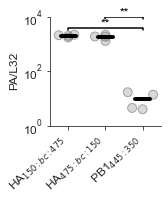

In [12]:
data = pd.read_csv('qPCR/HAcomparison.csv')
fig, ax = plt.subplots(1,1,figsize=[2,2])
order = ['HA150475', 'HA475150', 'PB1445350']
paletteOrder = ['0.5','0']
sns.swarmplot(y='PA', x='strain', data=data, palette = ['0.5'], edgecolor='0',        
                dodge=True, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3, clip_on=False)

plt.ylim(1,10000)
#a = plt.yticks(np.arange(0, 0.61, 0.1))
plt.yscale('log')
sns.despine()
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel('PA/L32')
#stats!
pvals = []
corresponding = []
for position, strain, in enumerate(order):
    for second, secondStrain in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_ind(data[data.strain == strain].PA, data[data.strain == secondStrain].PA )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
numPos = len(order) * 2
for position, val in enumerate(pvals):
    if val:
        x1, x2 = corresponding[position]
        x1 = ((x1*2+1)/numPos)
        x2 = ((x2*2+1)/numPos)
        
        y = 0.878 + offset*0.1
        h = 0.02
        ax.plot([x1, x1, x2, x2], [y,y+h, y+h, y], lw=1.5, c='k',transform=ax.transAxes)
        ax.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color='k',transform=ax.transAxes)
        offset += 1
    y = data[data.strain == order[position]].PA.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=8)
a = plt.xlabel('')
#change names to match manuscript
displayNames = ['HA$_{150:bc:475}$', 'HA$_{475:bc:150}$','PB1$_{445:350}$']
a =plt.xticks(np.arange(0,3,1),displayNames)
plt.savefig(figureDirectory + 'HAvariantPA_qPCR.pdf', bbox_inches="tight")

So, looking at our "stimulatory" HA, compared to our "non-stimulatory" PB1, what happens if we suppress replication?  Same conditions as above, but with 2h ribavirin pretreatment, 200µM

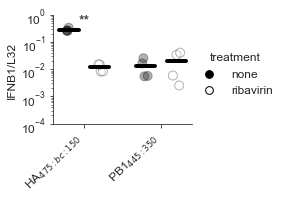

In [35]:
data = pd.read_csv('qPCR/HAPB1ribavirin.csv')
fig, ax = plt.subplots(1,1,figsize=[2.5,2])
order = ['HA475150', 'PB1445350']
paletteOrder = ['0','1']
hueOrder = ['none', 'ribavirin']


sns.stripplot(y='IFNB1', x='strain', data=data, hue='treatment', order = order, hue_order = hueOrder,
               palette =paletteOrder, edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False)



pvals = []
for position, strain in enumerate(order):
    curr = data[data['strain'] == strain]
    tstat, pval = stats.ttest_ind(curr[curr.treatment == 'none'].IFNB1, curr[curr.treatment == 'ribavirin'].IFNB1 )
    pvals += [pval]
    y = curr[curr.treatment == 'none'].IFNB1.mean()
    #plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='0.5', zorder=9)
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr.treatment == 'ribavirin'].IFNB1.mean()
    #plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='1', zorder=9)
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=8)                 

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = data[data.strain == order[position]].IFNB1.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
sns.despine()
plt.yscale('log')
plt.ylim(0.0001,1)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.yscale('log')
ax.get_legend().remove()

ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.,frameon=False, title='treatment')
displayNames = ['HA$_{475:bc:150}$', 'PB1$_{445:350}$']

a =plt.xticks(np.arange(0,2,1),displayNames)
a = plt.xlabel('')
plt.ylabel('IFNB1/L32')
a = plt.xticks(rotation=45, ha='right')

#from https://stackoverflow.com/questions/30887920/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

plt.savefig(figureDirectory + 'HAPB1ribavirinIFNB1_qPCR.pdf', bbox_inches="tight")


Ribavirin does not impact primary transcription.

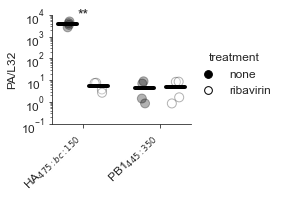

In [7]:
fig, ax = plt.subplots(1,1,figsize=[2.5,2])

sns.stripplot(y='PA', x='strain', data=data, hue='treatment', order = order, hue_order = hueOrder,
               palette =paletteOrder, edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False)



pvals = []
for position, strain in enumerate(order):
    curr = data[data['strain'] == strain]
    tstat, pval = stats.ttest_ind(curr[curr.treatment == 'none'].PA, curr[curr.treatment == 'ribavirin'].PA )
    pvals += [pval]
    y = curr[curr.treatment == 'none'].PA.mean()
    #plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='0.5', zorder=9)
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr.treatment == 'ribavirin'].PA.mean()
    #plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='1', zorder=9)
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=8)    
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = data[data.strain == order[position]].PA.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
sns.despine()
plt.yscale('log')
plt.ylim(0.1,10000)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.yscale('log')
ax.get_legend().remove()

ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.,frameon=False, title='treatment')
displayNames = ['HA$_{475:bc:150}$', 'PB1$_{445:350}$']
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

a =plt.xticks(np.arange(0,2,1),displayNames)
a = plt.xlabel('')
plt.ylabel('PA/L32')
a = plt.xticks(rotation=45, ha='right')
#from https://stackoverflow.com/questions/30887920/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 7)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

plt.savefig(figureDirectory + 'HAPB1ribavirinHA_qPCR.pdf', bbox_inches="tight")


Neuraminidase deletion for comparison. Values already corrected for L32. Numbers already log2 transformed

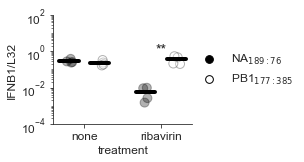

In [36]:
data = pd.read_csv('qPCR/NAsmalldel.csv')
fig, ax = plt.subplots(1,1,figsize=[2.5,2])
hueOrder= [ 'NA1901333', 'PB13852163']
paletteOrder = ['0','1']
order = ['none', 'ribavirin']


sns.stripplot(y='IFNB1', x='treatment', data=data, hue='strain', order = order, hue_order = hueOrder,
               palette =paletteOrder, edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False)



pvals = []
for position, treatment in enumerate(order):
    curr = data[data['treatment'] == treatment]
    tstat, pval = stats.ttest_ind(curr[curr.strain == 'NA1901333'].IFNB1, curr[curr.strain == "PB13852163"].IFNB1 )
    pvals += [pval]
    y = curr[curr.strain == 'NA1901333'].IFNB1.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr.strain == 'PB13852163'].IFNB1.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=8)                 

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = data[data.treatment == order[position]].IFNB1.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.ylim(0.0001,100)
plt.yscale('log')

sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

displayNames = ['NA$_{189:76}$','PB1$_{177:385}$']
ax.legend(handles[0:2], displayNames[0:2], bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.,frameon=False)

plt.ylabel('IFNB1/L32')
#from https://stackoverflow.com/questions/30887920/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

plt.savefig(figureDirectory + 'NAPB1ribavirinIFNB1_qPCR.pdf', bbox_inches="tight")

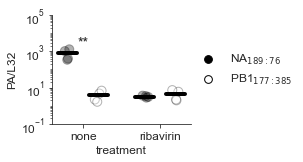

In [38]:
data = pd.read_csv('qPCR/NAsmalldel.csv')
fig, ax = plt.subplots(1,1,figsize=[2.5,2])
hueOrder= [ 'NA1901333', 'PB13852163']
paletteOrder = ['0','1']
order = ['none', 'ribavirin']


sns.stripplot(y='PA', x='treatment', data=data, hue='strain', order = order, hue_order = hueOrder,
               palette =paletteOrder, edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False)



pvals = []
for position, treatment in enumerate(order):
    curr = data[data['treatment'] == treatment]
    tstat, pval = stats.ttest_ind(curr[curr.strain == 'NA1901333'].PA, curr[curr.strain == "PB13852163"].PA )
    pvals += [pval]
    y = curr[curr.strain == 'NA1901333'].PA.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr.strain == 'PB13852163'].PA.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=8)                 

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = data[data.treatment == order[position]].PA.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.ylim(0.1,100000)
plt.yscale('log')

sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

displayNames = ['NA$_{189:76}$','PB1$_{177:385}$']
ax.legend(handles[0:2], displayNames[0:2], bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.,frameon=False)

plt.ylabel('PA/L32')
#from https://stackoverflow.com/questions/30887920/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

plt.savefig(figureDirectory + 'NAPB1ribavirinPA_qPCR.pdf', bbox_inches="tight")